In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import time
import os
import torch

from datasets.mnist import MNIST

from models.cae_model import CAE
from models.conv_model import CNN

from train import train_ae, train_cnn

from cem3 import ContrastiveExplanationMethod
from cem5 import ContrastiveExplanationMethod as ContrastiveExplanationMethod1

# set random seeds for reproducability (although the CEM is fully determininstic)
torch.manual_seed(0)
np.random.seed(0)

In [2]:
dataset = MNIST(batch_size=64)
# dataset = FashionMNIST()

# Training the classifier

In [3]:
cnn = CNN(device="cpu")

train_cnn(cnn, dataset, iterations=20, lr=0.01, save_fn='mnist-cnn', device="cpu", load_path="models/saved_models/mnist-cnn.h5")

In [4]:
images, _ = dataset.get_batch()

output = cnn(images)

images = images.numpy()
output = output.detach().numpy()


D:\david\Coding\uva-fact-ai\models\conv_model.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = nn.functional.softmax(out)


In [5]:
# # evaluate the cnn by uncommenting this cell

# total_acc = 0
# total_batches = 0
# for step, (batch_inputs, batch_targets) in enumerate(dataset.test_loader):
    
#     predictions = cnn(batch_inputs)
#     acc = (predictions.argmax(1).cpu().numpy() == batch_targets.cpu().numpy()).sum()/(predictions.shape[0] )
#     total_batches += 1
#     total_acc += acc
    
# print("acc: {}".format(total_acc / total_batches))

# Training the autoencoder

This section trains the autoencoder which will be used as regularizer for the data space which the perturbations are found in.

In [6]:
# Train or load autoencoder
cae = CAE(device="cpu")

train_ae(cae, dataset, iterations=10, save_fn="mnist-cae", device="cpu", load_path="models/saved_models/mnist-cae-no-rs.h5")

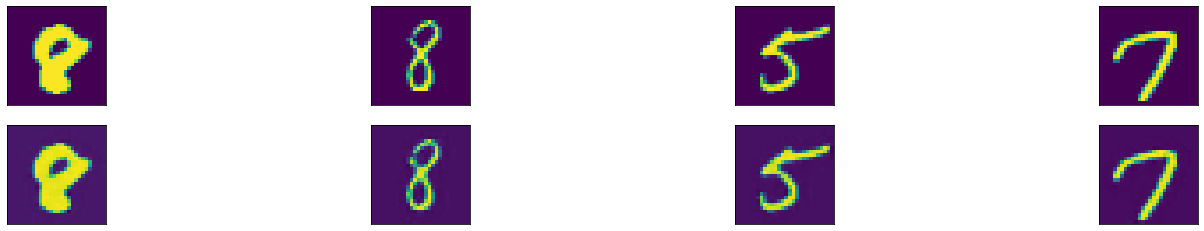

In [7]:
# obtain one batch of test images
images, _ = dataset.get_batch()
images += 0.5 # rescale images

# get sample outputs
output = cae(images)
# prep images for display
images = images.numpy()
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# Contrastive Explanation Method

In [8]:
# optimal: kappa 30, gamma 1.0, beta 0.1, lr 0.01

kappa = 30
gamma = 50
beta = 0.1
c = 0.1
lr = 0.01
CEM = ContrastiveExplanationMethod(
    cnn,
    cae,
    iterations=10,
    n_searches=2,
    kappa=kappa,
    gamma=gamma,
    beta=beta,
    learning_rate=lr,
    c_init=10.0
)
CEM1 = ContrastiveExplanationMethod1(
    cnn,
    cae,
    iterations=10,
    n_searches=2,
    kappa=kappa,
    gamma=gamma,
    beta=beta,
    learning_rate=lr,
    c_init=10.0,
    c_converge=c,
    verbal=True
)

In [9]:
def save_imgs():
    # save the created images
    dirname = "saved_perturbations/mode-{}-kappa-{}-gamma-{}-beta-{}-lr-{}".format(mode, kappa, gamma, beta, lr)
    os.makedirs(dirname, exist_ok=True)
    
    fname_orig = dirname + "/{}-cb-{}-ca-{}-orig.png".format(int(time.time()), before, after)
    fname_pert = dirname + "/{}-before-{}-after-{}-pert.png".format(int(time.time()), before, after)
    fname_combined = dirname + "/{}-before-{}-after-{}-pn.png".format(int(time.time()), before, after)
    fname_combined_pp = dirname + "/{}-before-{}-after-{}-pp.png".format(int(time.time()), before, after)
    
    plt.imsave(fname_orig, image.squeeze(), cmap="gray")
    plt.imsave(fname_pert, CEM.best_delta.view(28,28) - image.squeeze(), cmap="gray")
    plt.imsave(fname_combined, CEM.best_delta.view(28,28), cmap="gray")
    plt.imsave(fname_combined_pp, image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")

In [10]:
for i in range(1):
    # obtain one sample
    image = dataset.get_sample_by_class(class_label=i, show_image=False)

    print("IMAGE FROM CLASS: {}".format(i))
    before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
    
    for mode in ["PP", "PN"]:
        
        CEM.fista(image, mode=mode)
        
        if mode == "PP":
            after = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
        else:
            after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
        
        save_imgs()

IMAGE FROM CLASS: 0
search: 0 iteration: 1 c: 10.0 loss: 432.53 found optimum: False
search: 0 iteration: 2 c: 10.0 loss: 2954.83 found optimum: False
search: 0 iteration: 3 c: 10.0 loss: 2291.88 found optimum: False
search: 0 iteration: 4 c: 10.0 loss: 2359.06 found optimum: False
search: 0 iteration: 5 c: 10.0 loss: 2362.73 found optimum: False
search: 0 iteration: 6 c: 10.0 loss: 2364.29 found optimum: False
search: 0 iteration: 7 c: 10.0 loss: 2366.09 found optimum: False
search: 0 iteration: 8 c: 10.0 loss: 2361.59 found optimum: False
search: 0 iteration: 9 c: 10.0 loss: 2389.79 found optimum: False
search: 0 iteration: 10 c: 10.0 loss: 2408.15 found optimum: False
search: 1 iteration: 1 c: 100.0 loss: 2279.75 found optimum: False
search: 1 iteration: 2 c: 100.0 loss: 4657.81 found optimum: False
search: 1 iteration: 3 c: 100.0 loss: 4143.87 found optimum: False
new best: 3062.722412109375
search: 1 iteration: 4 c: 100.0 loss: 3062.72 found optimum: True
search: 1 iteration: 5 c:

In [11]:
for i in range(1):
    # obtain one sample
    image1 = dataset.get_sample_by_class(class_label=i, show_image=False)
    
    print("zelfde:", np.allclose(image, image1))
    
    print("IMAGE FROM CLASS: {}".format(i))
    before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
    
    for mode in ["PP", "PN"]:
        
        best_delta = CEM1.explain(image, mode=mode)
        
        if mode == "PP":
            after = np.argmax(cnn(image.squeeze(-1) - best_delta.view(1,28,28)).detach()).item()
        else:
            after = np.argmax(cnn(best_delta.view(1,28,28)).detach()).item()
        

zelfde: True
IMAGE FROM CLASS: 0
search: 0 iteration: 1 c: 10.0 loss: 432.53 found optimum: False
search: 0 iteration: 2 c: 10.0 loss: 2954.83 found optimum: False
search: 0 iteration: 3 c: 10.0 loss: 2291.88 found optimum: False
search: 0 iteration: 4 c: 10.0 loss: 2359.06 found optimum: False
search: 0 iteration: 5 c: 10.0 loss: 2362.73 found optimum: False
search: 0 iteration: 6 c: 10.0 loss: 2364.29 found optimum: False
search: 0 iteration: 7 c: 10.0 loss: 2366.09 found optimum: False
search: 0 iteration: 8 c: 10.0 loss: 2361.59 found optimum: False
search: 0 iteration: 9 c: 10.0 loss: 2389.79 found optimum: False
search: 0 iteration: 10 c: 10.0 loss: 2408.15 found optimum: False
search: 1 iteration: 1 c: 100.0 loss: 2279.75 found optimum: False
search: 1 iteration: 2 c: 100.0 loss: 4657.81 found optimum: False
search: 1 iteration: 3 c: 100.0 loss: 4143.87 found optimum: False
new best: 3062.722412109375
search: 1 iteration: 4 c: 100.0 loss: 3062.72 found optimum: True
search: 1 it

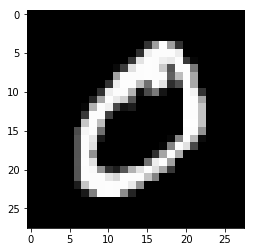

classification before perturbation: 0


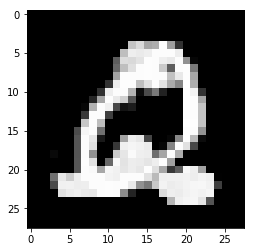

classification after perturbation: 2


In [12]:
# print original image
plt.imshow(image.view(28,28), cmap="gray")
plt.show()

# classification before
before = np.argmax(cnn(image.squeeze(-1)).detach()).item()
print("classification before perturbation: {}".format(before))

if mode == "PP":
    plt.imshow(image.squeeze() - CEM.best_delta.view(28,28), cmap="gray")
    plt.show()
    after = np.argmax(cnn(image.squeeze(-1) - CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification of delta: {}".format(after))
else:
    plt.imshow(CEM.best_delta.view(28,28),  cmap="gray")
    plt.show()
    after = np.argmax(cnn(CEM.best_delta.view(1,28,28)).detach()).item()
    print("classification after perturbation: {}".format(after))